&nbsp;

# 5. Regularization 
While training a machine learning model, the model can easily be overfitted or underfitted. 
To avoid this, we use regularization in machine learning to properly fit a model onto our test set. Overfitting occurs when the model learns too much detail and noise from the training data to the point when new data is exposed, the model will perform poorly on it. Regularization techniques help reduce the chance of overfitting by either adding penalties or stopping before the validation set's performance starts to decline. 

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing our functions. 
import functions
import plot_functions

# Importing emsemble models. 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

# Import transformers. 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, FunctionTransformer, LabelEncoder

# Converts plotly output into static images, so it can be viewed inside github repository. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Set up root directory.
df = pd.read_csv(r"{}\train.csv".format(root)) # Import train data. 
df = df.set_index("id") # Set paitent id as index. 

X = df.iloc[:,:-1] # Splitting features and labels. 
y = df.iloc[:,-1]

df.head(2)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
id,,,,,,,,,,,,,,,,,,,,,
896864,12.98,19.35,84.52,514.0,0.09579,0.11250,0.07107,0.02950,0.1761,0.06540,...,21.95,99.21,634.3,0.1288,0.32530,0.34390,0.09858,0.3596,0.09166,0
89382601,14.61,15.69,92.68,664.9,0.07618,0.03515,0.01447,0.01877,0.1632,0.05255,...,21.75,103.70,840.8,0.1011,0.07087,0.04746,0.05813,0.2530,0.05695,0


&nbsp;

### Section A: Overfitting
This section will focus on analyzing whether our classifiers overfitted on the training data. We want to avoid overfitting because if a model familiarises itself with the training data, it also inheirts its noise which would result in any predictions on unseen data to perform poorly. 

**A.1: Gradient Boosting Classifier**<br>
Let's check if our hypertuned Gradient Boosting Classifier overfitted.

In [3]:
overfitGBC = functions.model_evaluation()
overfitGBC.preprocessing(df)
overfitGBC.add_pipe_component("n", Normalizer())
overfitGBC.add_pipe_component("clf", GradientBoostingClassifier(learning_rate=0.1, max_depth=2, min_samples_split=30,
                                                               n_estimators=500))
pipe = Pipeline(steps=overfitGBC.estimators)
pipe = pipe.fit(X, y)
overfitGBC.overfitting_checker(X, y, pipe)

Model scored an Train_Recall_Score of: 100.00% and a Validation_Recall_Score of: 97.36%


**A.2: Random Forest Classifier**<br>
The next step is to check our Random Forest Classifier

In [4]:
overfitRFC = functions.model_evaluation()
overfitRFC.preprocessing(df)
overfitRFC.add_pipe_component("clf", RandomForestClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=2,
                                                               n_estimators=250))
pipe = Pipeline(steps=overfitRFC.estimators)
pipe = pipe.fit(X, y)
overfitRFC.overfitting_checker(X, y, pipe)

Model scored an Train_Recall_Score of: 97.20% and a Validation_Recall_Score of: 95.38%


**A.3: XGB Classifier**<br>
Finally, we can test if our XGB Classifier overfitted.

In [5]:
overfitXGB = functions.model_evaluation()
overfitXGB.preprocessing(df)
overfitXGB.add_pipe_component("n", Normalizer())
overfitXGB.add_pipe_component("clf", XGBClassifier(learning_rate=0.1, max_depth=2, min_child_weight=1,
                                                               n_estimators=250))
pipe = Pipeline(steps=overfitXGB.estimators)
pipe = pipe.fit(X, y)
overfitXGB.overfitting_checker(X, y, pipe)

Model scored an Train_Recall_Score of: 100.00% and a Validation_Recall_Score of: 96.70%


* It looks like all of our classifiers contain some degree of overfitting. So the next section will be focused on limiting it.

| Model | Model Type | Train Recall | Validation Recall |
|---------|---------|---------|---------|
| **Gradient Boosting Classifier** |  Normalized | 100.00% |97.36% |
| **Random Forest Classifier** |  Base Model | 96.87% |95.60% |
| **XGB Classifier** |  Normalized | 100.00% |96.70% |

&nbsp;

### Section B: Regularization
This section will focus on enabling regularization techniques for all our chosen models to counter overfitting. Regularization is the process of adding penalties or early stopping to prevent a model from overfitting to the training data.

**B.1: Regularizing Gradient Boosting Classifier**<br>
To enable early stopping for our Gradient Boosting Classifier, we include the "n_iter_no_change" (early stopping), "validation_fraction" (validation set %) and "tol" (tolerance level).

In [6]:
testGBC, trainGBC, testTrainDifference = list(), list(), list()

# ML algorithms are stochastic in nature, so we'll evlauate our model through 10 iterations. 
for i in range(1,11): 
    GBC = functions.model_evaluation() # Creating our class instance. 
    GBC.preprocessing(df) 
    # Adding transformers to pipeline.
    GBC.add_pipe_component("n", Normalizer())
    GBC.add_pipe_component("clf", GradientBoostingClassifier(learning_rate=0.1, max_depth=2, min_samples_split=30, 
                                                            n_estimators=500, validation_fraction=0.2,
                                                            n_iter_no_change=15, tol=0.1))
    pipe = Pipeline(steps=GBC.estimators) # Creating pipeline instance.  
    pipe = pipe.fit(X, y) # Fitting the data to our estimator. 
    GBC.overfitting_checker_no_print(X, y, pipe) # Evaluation using cross validation, enabling train score. 
    
    # Storing average results.  
    trainGBC.append(GBC.results["train_score"].mean()*100)
    testGBC.append(GBC.results["test_score"].mean()*100)
    testTrainDifference.append(round(GBC.results["test_score"].mean() - GBC.results["train_score"].mean(), 2))
    
print('Model scored an Train_Recall_Score of: %.2f%% and a Validation_Recall of: %.2f%% and the difference between the two is: %.2f%%' 
      % (np.mean(trainGBC), np.mean(testGBC), np.mean(testTrainDifference)*100))

Model scored an Train_Recall_Score of: 98.47% and a Validation_Recall of: 94.81% and the difference between the two is: -3.70%


**B.2: Regularizing Random Forest Classifier**<br>
To regularize our Random Forest Classifier we increased our min_samples_split to 15.

In [7]:
testRFC, trainRFC, testTrainDifference2 = list(), list(), list()

for i in range(1,11):
    # Check if the model overfit. 
    RFC = functions.model_evaluation()
    RFC.preprocessing(df)
    # Checking if our hypertuned models overfited.
    RFC.add_pipe_component("clf", RandomForestClassifier(max_depth=20, min_samples_split=15, min_samples_leaf=2, 
                                                               n_estimators=250))
    pipe = Pipeline(steps=RFC.estimators)
    pipe = pipe.fit(X, y)
    RFC.overfitting_checker_no_print(X, y, pipe) 
    
    # Storing average results.  
    trainRFC.append(RFC.results["train_score"].mean()*100)
    testRFC.append(RFC.results["test_score"].mean()*100)
    testTrainDifference2.append(round(RFC.results["test_score"].mean() - RFC.results["train_score"].mean(),2 ))
    
print('Model scored an Train_Recall_Score of: %.2f%% and a Validation_Recall of: %.2f%% and the difference between the two is: %.2f%%' 
      % (np.mean(trainRFC), np.mean(testRFC), np.mean(testTrainDifference2)*100))

Model scored an Train_Recall_Score of: 98.45% and a Validation_Recall of: 95.38% and the difference between the two is: -3.10%


| Model | Model Type | Regularization Metrics | Recall |
|---------|---------|---------|---------|
| **Gradient Boosting Classifier** | Normalized|validation_fraction=0.2, n_iter_no_change=15, tol=0.1 | 94.70% |
| **Random Forest Classifier** | Base Model | min_samples_split=10, max_depth=20 |95.60% |

**B.3: Regularizing XGB Classifier**<br>
To regularize our XGB Regressor we can implement the early stopping technique. This method involves the algorithm to stop training n number of epochs once the loss function of the validation set starts to deteroriate.

In [8]:
n = Normalizer() # Creating our normalizer instance. 
normalizedData = n.fit_transform(X) # Transforming our feature space. 
dfNormalized = pd.DataFrame(data=normalizedData, columns=list(X.columns)) # Output results into a dataframe. 
dfNormalized.head(2)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.015681,0.023376,0.102107,0.620954,0.000116,0.000136,0.000086,0.000036,0.000213,0.000079,...,0.017421,0.026517,0.119854,0.766286,0.000156,0.000393,0.000415,0.000119,0.000434,0.000111
1,0.013505,0.014503,0.085667,0.614589,0.000070,0.000032,0.000013,0.000017,0.000151,0.000049,...,0.015215,0.020104,0.095853,0.777179,0.000093,0.000066,0.000044,0.000054,0.000234,0.000053


In [9]:
# Getting axes. 
XGB = functions.Early_Stopping(dfNormalized, y, XGBClassifier(eval_metric=["logloss"], learning_rate=0.1, max_depth=2, 
                                                   min_child_weight=1, n_estimators=250))

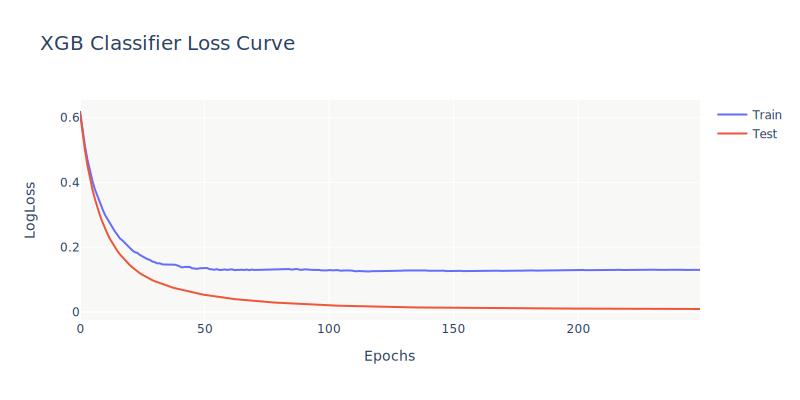

In [10]:
# Inputting axes into our plot. 
plot_functions.LogLoss_Curve(XGB.x_axis, XGB.results["validation_1"]['logloss'], 
                        XGB.results["validation_0"]['logloss'])

In [11]:
# We'll set "n_estimators" to 500, to ensure the model has enough training time to overfit. 
earlyStoppingXGB = functions.Early_Stopping(dfNormalized, y, XGBClassifier(early_stopping_rounds=10, eval_metric=["logloss"], 
                                                    learning_rate=0.1,max_depth=2, min_child_weight=1, n_estimators=500))

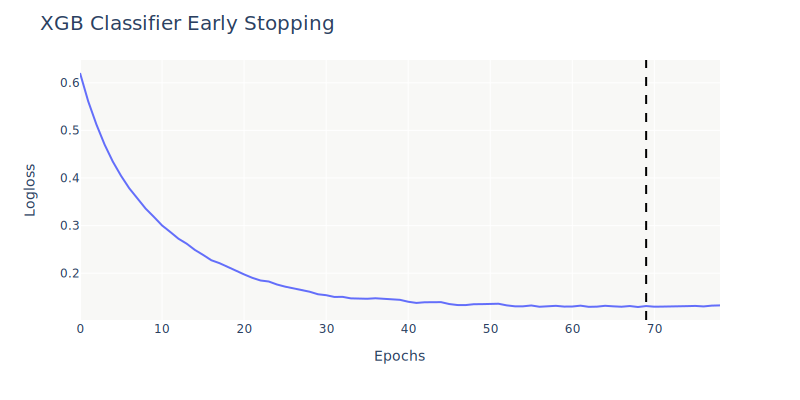

The model stopped training at around 78 epochs, with the best loss score observed at: 69.


In [12]:
# Plot early stopping results. 
fig = px.line(x=earlyStoppingXGB.x_axis, y=earlyStoppingXGB.results['validation_1']['logloss'])
fig.add_vline(x=earlyStoppingXGB.clf.best_ntree_limit, line_width=2, line_dash="dash", line_color="black") # Best loss score. 
fig.update_layout(title='XGB Classifier Early Stopping',
                       xaxis_title='Epochs',
                       yaxis_title='Logloss',
                       height=400, width=800, plot_bgcolor='#F8F8F6', title_font_size=20, 
                       title_font_family='Arial Black')
fig.show()

print("The model stopped training at around 78 epochs, with the best loss score observed at: %.0f." % (
    earlyStoppingXGB.clf.best_ntree_limit))
# Now we know that we should set our number of trees (n_estimator) to =69 to avoid overfitting.

&nbsp;

### Section C: Threshold Manipulation
Threshold manipulation is the process of changing the default threshold value used to classify predictions into classes. We can create an array of threshold values and iterate through them to optimize for our weighted recall evaluation metric. 

Since algorithms are stochastic in nature we will run our expirement through 10 iterations and record the threshold that outputs the highest score. 

**C.1: Gradient Boosting Classifier Optimal Threshold**<br>
Now it's time to explore some threshold values on our Gradient Boosting Classifier.

Threshold=0.247, Recall_Score=0.94505


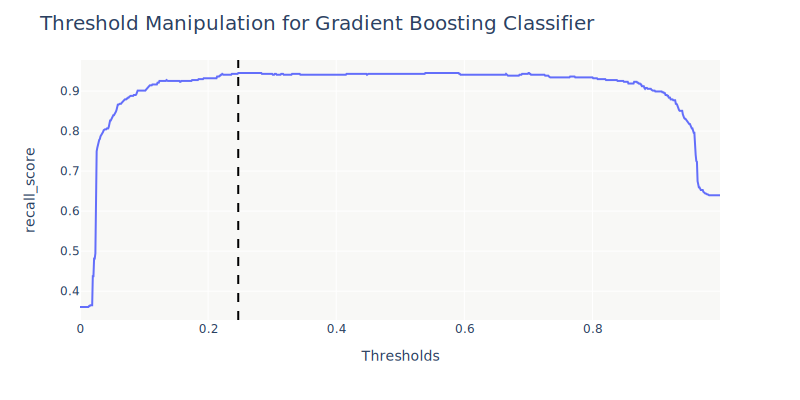

In [13]:
# Evaluating our array of threshold values and output the best recall score. 
plot_functions.threshold_manipulation(dfNormalized, y, GradientBoostingClassifier(learning_rate=0.1, max_depth=2,
                                                  min_samples_split=30, n_estimators=500, validation_fraction=0.2,
                                                  n_iter_no_change=15, tol=0.1), "Gradient Boosting Classifier")

**C.2: Random Forest Classifier Optimal Threshold**<br>
The next step is to repeat the process for our Random Forest Classifier.

Threshold=0.396, Recall_Score=0.95824


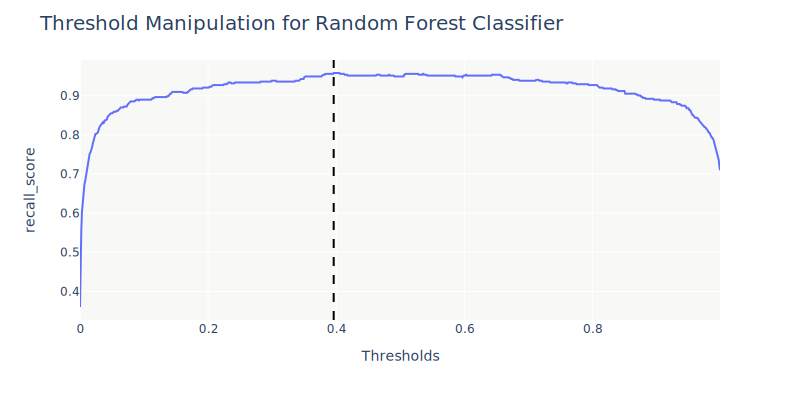

In [14]:
plot_functions.threshold_manipulation(X, y, RandomForestClassifier(max_depth=20, min_samples_split=10, min_samples_leaf=2, 
                                                               n_estimators=250), "Random Forest Classifier")

**C.3: XGB Classifier Optimal Threshold**<br>
Finally, testing our threshold function on our XGB Classifier.

Threshold=0.648, Recall_Score=0.96044


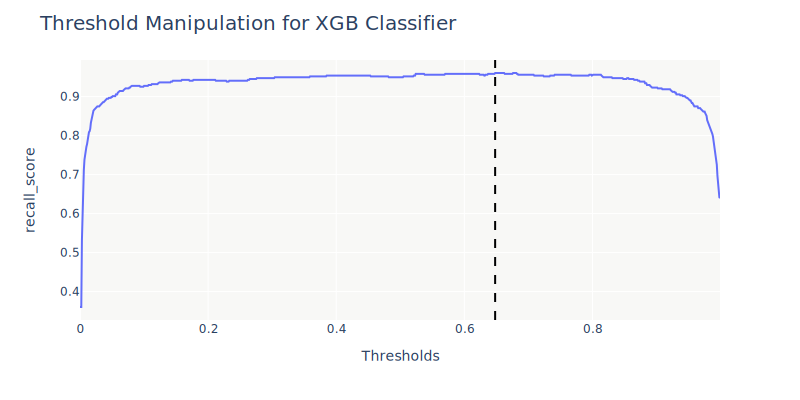

In [15]:
# Setting n_estimators=69, for early stopping. 
plot_functions.threshold_manipulation(dfNormalized, y, XGBClassifier(learning_rate=0.1,max_depth=2, min_child_weight=1,
                                                                n_estimators=69), "XGB Classifier")

**C.4: Conclusion**<br>
To sum up, we successfully regularized our regressor models through early stopping and managed to soften the impact of overfitting, whilst still retaining our strong validation performance. With all our models regularized and fitted with the best combination of hyperparameters and thresholds it is now time to truely test our algorithms on the holdout dataset, that we put aside from the beginning of the project.

&nbsp;

| Model | Model Type | Regularized Hyperparameters |Threshold | 
|---------|---------|---------|---------|
| **Gradient Boosting Classifier** | Normalized   |learning_rate=0.1, max_depth=2, min_samples_split=30, n_estimators=500, <br>validation_fraction=0.2, n_iter_no_change=15, tol=0.1 |  0.454   |
| **Random Forest Classifier** | Base Model |max_depth=20, min_samples_split=10, min_samples_leaf=2,  n_estimators=250 | 0.497   |
| **XGB Classifier** | Normalized | learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=69 | 0.648   |

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  